In [265]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        print('CLASS')
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        print('REG')
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Function to plot results
def plot(results):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for activation in results['Activation'].unique():
        subset = results[results['Activation'] == activation]
        ax.plot(subset['Neurons'].astype(str), subset['RMSE'], marker='o', label=activation)

    ax.set_title('Model Performance by Activation Function')
    ax.set_xlabel('Layer Configuration (Neurons)')
    ax.set_ylabel('RMSE')
    ax.legend(title='Activation Function')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    plt.plot(t['pred'].tolist(), label='Prediction', color='orange')
    plt.plot(t['y'].tolist(), label='Expected', color='blue')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)
    return df

# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [266]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [267]:
import os
import pandas as pd
import numpy as np

#Set paths and set option to print entire tables
path = "./data/"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Set paths for CSV
train_path = os.path.join(path,"UNSW_NB15_training-set.csv")
test_path = os.path.join(path,"UNSW_NB15_test-set.csv")

#Read the CSVs 
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

#Fix ID's Name
train_df.rename(columns={'ï»¿id': 'id'}, inplace=True)
test_df.rename(columns={'ï»¿id': 'id'}, inplace=True)

#Replace '-' (missing value) with NA
train_df.replace('-', pd.NA, inplace=True)
test_df.replace('-', pd.NA, inplace=True)
  
#Drop missing values
train_df = train_df.dropna()
test_df = test_df.dropna()

##TO-DO, DROP UNIQUE ROWS
test_df[0:10]


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
35,36,0.983874,tcp,http,FIN,10,8,816,1172,17.278635,62,252,5976.375000,8342.531250,2,2,109.319333,124.932859,5929.211713,192.590406,255,794167371,1624757001,255,0.206572,0.108393,0.098179,82,147,1,184,2,1,1,1,1,2,0,0,1,1,3,0,Normal,0
40,41,1.535254,tcp,http,FIN,10,10,826,1266,12.375802,62,252,3876.882812,5940.385254,2,2,170.481889,159.070562,11933.065600,244.118016,255,708428911,3141441573,255,0.180318,0.103612,0.076706,83,127,1,187,2,1,1,1,1,2,0,0,1,1,3,0,Normal,0
45,46,1.059359,tcp,http,FIN,10,8,830,1134,16.047441,62,252,5641.147461,7498.874512,2,2,117.706556,132.899281,6102.668305,255.756219,255,1853677305,1202418679,255,0.274887,0.128459,0.146428,83,142,1,165,1,1,1,1,1,1,0,0,1,3,1,0,Normal,0
49,50,0.990548,tcp,http,FIN,10,10,804,1414,19.181301,62,252,5847.268066,10281.177730,2,2,110.060889,100.616555,7172.956819,143.497953,255,1528762476,1066585482,255,0.181441,0.084249,0.097192,80,141,1,261,2,1,18,1,1,2,0,0,1,1,2,0,Normal,0
72,73,1.303518,tcp,http,FIN,12,8,898,1120,14.575939,62,252,5057.083984,6014.492676,2,2,118.501635,175.467000,6491.561713,252.408328,255,1182907296,802589817,255,0.140062,0.074510,0.065552,75,140,1,157,1,1,1,1,1,1,0,0,1,2,1,0,Normal,0
89,90,2.417396,tcp,http,FIN,12,10,896,1142,8.687033,62,252,2720.282471,3402.007568,2,2,219.671639,251.911219,13318.121680,368.903437,255,1647371567,938705912,255,0.301504,0.150194,0.151310,75,114,1,126,1,1,2,1,1,1,0,0,1,1,1,0,Normal,0
99,100,1.979445,tcp,http,FIN,10,10,810,1228,9.598650,62,252,2946.280518,4469.939941,2,2,219.938333,211.908000,14679.526850,514.389156,255,504743724,17824254,255,0.141090,0.071357,0.069733,81,123,1,168,2,1,1,1,1,2,0,0,1,1,2,0,Normal,0
116,117,1.538604,tcp,http,FIN,10,10,814,1266,12.348856,62,252,3811.247070,5927.451172,2,2,170.860889,158.795219,9513.325933,271.657688,255,664847518,2707919610,255,0.333902,0.109439,0.224463,81,127,1,188,2,1,1,1,1,2,0,0,1,2,2,0,Normal,0
130,131,1.625287,tcp,http,FIN,12,8,876,1182,11.690243,62,252,3952.532471,5094.484863,2,2,147.753369,221.341281,7502.326999,308.739156,255,1189974610,4041664482,255,0.184153,0.075141,0.109012,73,148,1,189,1,1,2,1,1,1,0,0,1,1,1,0,Normal,0
135,136,1.048635,tcp,http,FIN,10,8,824,1206,16.211551,62,252,5660.692383,8056.187500,2,2,116.515000,129.349430,6160.721977,249.897156,255,3719681799,1268959706,255,0.263248,0.142526,0.120722,82,151,1,201,4,1,1,1,1,4,0,0,1,1,4,0,Normal,0


In [268]:
# Send the expected numeric and categorical columns to normalization. Send target to text_index.  
NumericColumns = ['dur','spkts','dpkts','sbytes','dbytes','rate','sttl','dttl','sload','dload','sloss','dloss','sinpkt','dinpkt','sjit','djit','swin','stcpb','dtcpb','tcprtt',
               'synack','ackdat','smean','dmean','trans_depth','response_body_len','ct_srv_src','ct_state_ttl','ct_dst_ltm','ct_dst_sport_ltm','ct_dst_src_ltm','is_ftp_login','ct_ftp_cmd',
               'ct_flw_http_mthd','ct_src_ltm','ct_srv_dst','is_sm_ips_ports']
CategoricalColumns = ['proto', 'service', 'state','attack_cat'] 
for i in NumericColumns:  
    encode_numeric_zscore(train_df,i)
    encode_numeric_zscore(test_df,i)
for i in CategoricalColumns:
    encode_text_index(train_df,i)
    encode_text_index(test_df,i)
sdnum=3
train_df = remove_outliers(train_df, 'dur', sd=sdnum)
test_df = remove_outliers(test_df, 'dur', sd=sdnum)
train_df = remove_outliers(train_df, 'spkts', sd=sdnum)
test_df = remove_outliers(test_df, 'spkts', sd=sdnum)
train_df = remove_outliers(train_df, 'dpkts', sd=sdnum)
test_df = remove_outliers(test_df, 'dpkts', sd=sdnum)
train_df = remove_outliers(train_df, 'sbytes', sd=sdnum)
test_df = remove_outliers(test_df, 'sbytes', sd=sdnum)
train_df = remove_outliers(train_df, 'dbytes', sd=sdnum)
test_df = remove_outliers(test_df, 'dbytes', sd=sdnum)
train_df = remove_outliers(train_df, 'rate', sd=sdnum)
test_df = remove_outliers(test_df, 'rate', sd=sdnum)
train_df = remove_outliers(train_df, 'sttl', sd=sdnum)
test_df = remove_outliers(test_df, 'sttl', sd=sdnum)
train_df = remove_outliers(train_df, 'dttl', sd=sdnum)
test_df = remove_outliers(test_df, 'dttl', sd=sdnum)
train_df = remove_outliers(train_df, 'sload', sd=sdnum)
test_df = remove_outliers(test_df, 'sload', sd=sdnum)
train_df = remove_outliers(train_df, 'dload', sd=sdnum)
test_df = remove_outliers(test_df, 'dload', sd=sdnum)
train_df = remove_outliers(train_df, 'sloss', sd=sdnum)
test_df = remove_outliers(test_df, 'sloss', sd=sdnum)
train_df = remove_outliers(train_df, 'dloss', sd=sdnum)
test_df = remove_outliers(test_df, 'dloss', sd=sdnum)
train_df = remove_outliers(train_df, 'sinpkt', sd=sdnum)
test_df = remove_outliers(test_df, 'sinpkt', sd=sdnum)
train_df = remove_outliers(train_df, 'dinpkt', sd=sdnum)
test_df = remove_outliers(test_df, 'dinpkt', sd=sdnum)
train_df = remove_outliers(train_df, 'sjit', sd=sdnum)
test_df = remove_outliers(test_df, 'sjit', sd=sdnum)
train_df = remove_outliers(train_df, 'djit', sd=sdnum)
test_df = remove_outliers(test_df, 'djit', sd=sdnum)
train_df = remove_outliers(train_df, 'synack', sd=sdnum)
test_df = remove_outliers(test_df, 'synack', sd=sdnum)
train_df = remove_outliers(train_df, 'ackdat', sd=sdnum)
test_df = remove_outliers(test_df, 'ackdat', sd=sdnum)
train_df = remove_outliers(train_df, 'smean', sd=sdnum)
test_df = remove_outliers(test_df, 'smean', sd=sdnum)
train_df = remove_outliers(train_df, 'dmean', sd=sdnum)
test_df = remove_outliers(test_df, 'dmean', sd=sdnum)
train_df = remove_outliers(train_df, 'trans_depth', sd=sdnum)
test_df = remove_outliers(test_df, 'trans_depth', sd=sdnum)
train_df = remove_outliers(train_df, 'response_body_len', sd=sdnum)
test_df = remove_outliers(test_df, 'response_body_len', sd=sdnum)
#train_df = remove_outliers(train_df, 'ct_srv_src', sd=sdnum)
#test_df = remove_outliers(test_df, 'ct_srv_src', sd=sdnum)
#train_df = remove_outliers(train_df, 'ct_state_ttl', sd=sdnum)
#test_df = remove_outliers(test_df, 'ct_state_ttl', sd=sdnum)
#train_df = remove_outliers(train_df, 'ct_dst_ltm', sd=sdnum)
#test_df = remove_outliers(test_df, 'ct_dst_ltm', sd=sdnum)
#train_df = remove_outliers(train_df, 'ct_dst_sport_ltm', sd=sdnum)
#test_df = remove_outliers(test_df, 'ct_dst_sport_ltm', sd=sdnum)
#train_df = remove_outliers(train_df, 'ct_flw_http_mthd', sd=sdnum)
#test_df = remove_outliers(test_df, 'ct_flw_http_mthd', sd=sdnum)
#train_df = remove_outliers(train_df, 'ct_src_ltm', sd=sdnum)
#test_df = remove_outliers(test_df, 'ct_src_ltm', sd=sdnum)

train_df.drop(columns=['is_sm_ips_ports'], inplace=True)
test_df.drop(columns=['is_sm_ips_ports'], inplace=True)
train_df.drop(columns=['dwin'], inplace=True)
test_df.drop(columns=['dwin'], inplace=True)
train_df[0:10]
sorted_df = train_df.sort_values(by='sload', ascending=False)
sorted_df[0:10]

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,attack_cat,label
101589,101590,-0.198899,1,1,2,-0.100988,-0.135525,-0.057770,-0.082207,0.540298,0.822646,-0.717582,1.107662,-0.219823,-0.072328,-0.102787,-0.182299,-0.15917,-0.137528,-0.179661,-0.843349,-0.67236,-0.67392,-0.548899,-0.511111,-0.542046,-0.193898,-0.486063,-0.197312,-0.05778,-0.931741,0.851546,-0.911291,1,-0.890285,-0.939620,-0.175733,-0.175733,-0.278273,-0.955804,-0.927297,2,1
80727,80728,-0.198900,1,9,2,-0.100988,-0.135525,-0.057916,-0.082207,0.831423,0.822646,-0.717582,1.092853,-0.219823,-0.072328,-0.102787,-0.182303,-0.15917,-0.137528,-0.179661,-0.843349,-0.67236,-0.67392,-0.548899,-0.511111,-0.542046,-0.278781,-0.486063,-0.197312,-0.05778,-0.931741,0.851546,-0.911291,1,-0.890285,-0.939620,-0.175733,-0.175733,-0.278273,-0.855604,-0.927297,7,1
52985,52986,-0.198900,1,9,2,-0.100988,-0.135525,-0.057916,-0.082207,0.831423,0.822646,-0.717582,1.092853,-0.219823,-0.072328,-0.102787,-0.182303,-0.15917,-0.137528,-0.179661,-0.843349,-0.67236,-0.67392,-0.548899,-0.511111,-0.542046,-0.278781,-0.486063,-0.197312,-0.05778,-0.931741,0.851546,-0.911291,1,-0.890285,-0.865254,-0.175733,-0.175733,-0.278273,-0.755403,-0.927297,7,1
121170,121171,-0.198900,1,9,2,-0.100988,-0.135525,-0.057924,-0.082207,0.831423,0.822646,-0.717582,1.068172,-0.219823,-0.072328,-0.102787,-0.182303,-0.15917,-0.137528,-0.179661,-0.843349,-0.67236,-0.67392,-0.548899,-0.511111,-0.542046,-0.283496,-0.486063,-0.197312,-0.05778,-0.931741,0.851546,-0.911291,1,-0.890285,-0.939620,-0.175733,-0.175733,-0.278273,-0.955804,-0.927297,7,1
79930,79931,-0.198900,1,9,2,-0.100988,-0.135525,-0.057924,-0.082207,0.831423,0.822646,-0.717582,1.068172,-0.219823,-0.072328,-0.102787,-0.182303,-0.15917,-0.137528,-0.179661,-0.843349,-0.67236,-0.67392,-0.548899,-0.511111,-0.542046,-0.283496,-0.486063,-0.197312,-0.05778,-0.931741,0.851546,-0.911291,1,-0.890285,-0.939620,-0.175733,-0.175733,-0.278273,1.048210,-0.927297,2,1
116929,116930,-0.198900,1,1,2,-0.100988,-0.135525,-0.057933,-0.082207,0.831423,-1.042527,-0.717582,1.043491,-0.219823,-0.072328,-0.102787,-0.182303,-0.15917,-0.137528,-0.179661,-0.843349,-0.67236,-0.67392,-0.548899,-0.511111,-0.542046,-0.288212,-0.486063,-0.197312,-0.05778,-0.708574,0.851546,-0.811222,2,-0.749320,-0.716523,-0.175733,-0.175733,-0.278273,-0.755403,-0.704475,3,1
78290,78291,-0.198900,1,1,2,-0.100988,-0.135525,-0.057933,-0.082207,0.831423,-1.042527,-0.717582,1.043491,-0.219823,-0.072328,-0.102787,-0.182303,-0.15917,-0.137528,-0.179661,-0.843349,-0.67236,-0.67392,-0.548899,-0.511111,-0.542046,-0.288212,-0.486063,-0.197312,-0.05778,-0.782963,0.851546,-0.911291,1,-0.890285,-0.790888,-0.175733,-0.175733,-0.278273,-0.955804,-0.778749,3,1
112947,112948,-0.198900,1,1,2,-0.100988,-0.135525,-0.057933,-0.082207,0.831423,-1.042527,-0.717582,1.043491,-0.219823,-0.072328,-0.102787,-0.182303,-0.15917,-0.137528,-0.179661,-0.843349,-0.67236,-0.67392,-0.548899,-0.511111,-0.542046,-0.288212,-0.486063,-0.197312,-0.05778,-0.782963,0.851546,-0.811222,2,-0.749320,-0.790888,-0.175733,-0.175733,-0.278273,-0.855604,-0.778749,3,1
139308,139309,-0.198900,1,1,2,-0.100988,-0.135525,-0.057933,-0.082207,0.831423,-1.042527,-0.717582,1.043491,-0.219823,-0.072328,-0.102787,-0.182303,-0.15917,-0.137528,-0.179661,-0.843349,-0.67236,-0.67392,-0.548899,-0.511111,-0.542046,-0.288212,-0.486063,-0.197312,-0.05778,-0.708574,0.851546,-0.811222,2,-0.749320,-0.716523,-0.175733,-0.175733,-0.278273,-0.855604,-0.704475,3,1
160431,160432,-0.198899,1,9,2,-0.100988,-0.135525,-0.057260,-0.082207,0.022742,0.822646,-0.717582,1.035264,-0.219823,-0.072328,-0.102787,-0.182282,-0.15917,-0.137528,-0.179661,-0.843349,-0.67236,-0.67392,-0.548899,-0.511111,-0.542046,0.103190

In [269]:
columns_of_interest = ['proto', 'service', 'state', 'attack_cat']
common_categories_dict = {}

#Get common categories for each column
for column in columns_of_interest:
    train_categories = set(train_df[column].unique())
    test_categories = set(test_df[column].unique())
    common_categories_dict[column] = train_categories.intersection(test_categories)

#Filter the DataFrames for each column based on common categories
for column in columns_of_interest:
    train_df = train_df[train_df[column].isin(common_categories_dict[column])]
    test_df = test_df[test_df[column].isin(common_categories_dict[column])]

#Check unique values
for column in columns_of_interest:
    print(f"Filtered Train {column} Categories:", train_df[column].unique())
    print(f"Filtered Test {column} Categories:", test_df[column].unique())


Filtered Train proto Categories: [1 0]
Filtered Test proto Categories: [0 1]
Filtered Train service Categories: [1 9 4 0 7]
Filtered Test service Categories: [3 9 0 1 4 7]
Filtered Train state Categories: [0 2 1 3]
Filtered Test state Categories: [2 3 1 0]
Filtered Train attack_cat Categories: [6 4 2 5]
Filtered Test attack_cat Categories: [2 6 4 5]


CLASS
CLASS
Train X shape: (36904, 42)
Train Y shape: (36904, 2)
Test X shape: (18055, 42)
Test Y shape: (18055, 2)
Epoch 1/100


c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1154/1154 - 2s - 2ms/step - loss: 180.2826 - val_loss: 48.3381
Epoch 2/100
1154/1154 - 1s - 1ms/step - loss: 18.5986 - val_loss: 1.5078
Epoch 3/100
1154/1154 - 1s - 1ms/step - loss: 7.5785 - val_loss: 0.8892
Epoch 4/100
1154/1154 - 1s - 1ms/step - loss: 0.0692 - val_loss: 0.3191
Epoch 5/100
1154/1154 - 1s - 1ms/step - loss: 2.7220 - val_loss: 0.2592
Epoch 6/100
1154/1154 - 1s - 1ms/step - loss: 0.0031 - val_loss: 0.3412
Epoch 7/100
1154/1154 - 1s - 1ms/step - loss: 0.3039 - val_loss: 0.1423
Epoch 8/100
1154/1154 - 1s - 1ms/step - loss: 1.4901e-04 - val_loss: 0.1085
Epoch 9/100
1154/1154 - 1s - 1ms/step - loss: 1.4497e-05 - val_loss: 0.1595
Epoch 10/100
1154/1154 - 1s - 1ms/step - loss: 1.8426e-05 - val_loss: 0.1192
Epoch 11/100
1154/1154 - 1s - 1ms/step - loss: 6.0364e-06 - val_loss: 0.1394
Epoch 12/100
1154/1154 - 1s - 1ms/step - loss: 4.1120 - val_loss: 0.2508
Epoch 13/100
1154/1154 - 1s - 1ms/step - loss: 6.8981e-04 - val_loss: 0.2587
Epoch 13: early stopping
Epoch 1/100
1154/1154 -

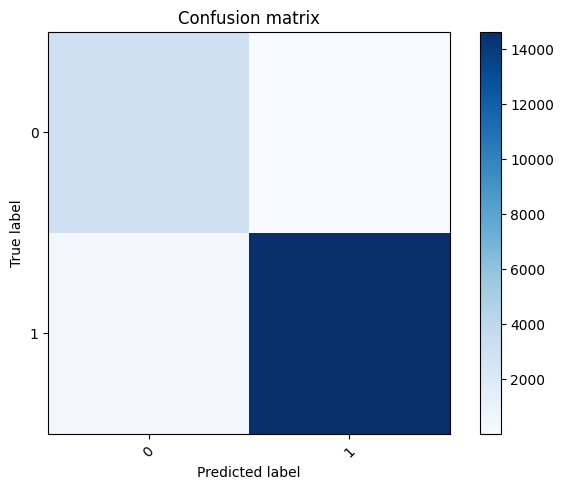

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      3057
           1       1.00      0.98      0.99     14998

    accuracy                           0.98     18055
   macro avg       0.95      0.99      0.97     18055
weighted avg       0.98      0.98      0.98     18055

565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


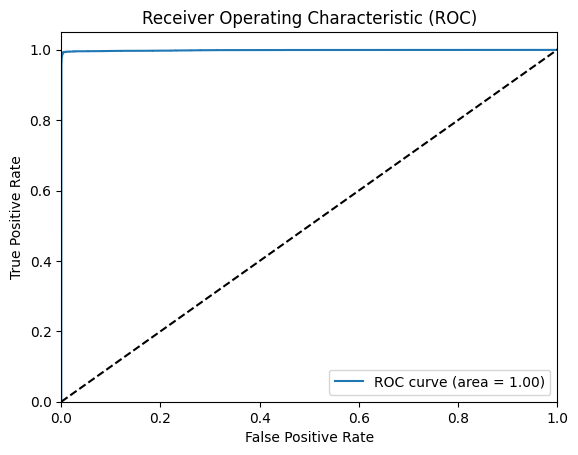

In [270]:
label = encode_text_index(train_df,"label")
x, y = to_xy(train_df, "label")
x_test, y_test = to_xy(test_df, "label")

print("Train X shape:", x.shape)
print("Train Y shape:", y.shape)
print("Test X shape:", x_test.shape)
print("Test Y shape:", y_test.shape)

checkpointer = ModelCheckpoint(filepath="dnn/model.keras", verbose=0, save_best_only=True) # save best model
for i in range(2):
    model = Sequential()
    model.add(Dense(500, input_dim=x.shape[1], activation='relu')) # More neurons
    model.add(Dropout(0.1))  # Dropout to reduce overfitting
    model.add(Dense(2, activation='softmax')) # Output layer
    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto') 
    model.fit(x, y, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer], verbose=2, epochs=100)

model.load_weights('dnn/model.keras') # load weights from best model 

import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, label)
plt.show()
print(classification_report(y_true, pred))

y_true = np.argmax(y_test, axis=1)
pred = model.predict(x_test)
pred = pred[:, 1]
plot_roc(pred, y_true)

### CNN Model


Epoch 1/10


c:\Users\nicol\OneDrive\Desktop\CodingFiles\CSC 180\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


289/289 - 5s - 16ms/step - accuracy: 0.9651 - loss: 23.5290 - val_accuracy: 0.5125 - val_loss: 149.2142
Epoch 2/10
289/289 - 3s - 11ms/step - accuracy: 0.9998 - loss: 0.0207 - val_accuracy: 0.5130 - val_loss: 136.3997
Epoch 3/10
289/289 - 3s - 11ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.5133 - val_loss: 112.7650
Epoch 4/10
289/289 - 4s - 12ms/step - accuracy: 0.9998 - loss: 0.0128 - val_accuracy: 0.5125 - val_loss: 176.2800
Epoch 5/10
289/289 - 3s - 12ms/step - accuracy: 0.9999 - loss: 0.0077 - val_accuracy: 0.5133 - val_loss: 139.0905
Epoch 6/10
289/289 - 3s - 11ms/step - accuracy: 0.9999 - loss: 0.0077 - val_accuracy: 0.5133 - val_loss: 84.7054
Epoch 7/10
289/289 - 3s - 12ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.5133 - val_loss: 130.8147
Epoch 8/10
289/289 - 3s - 12ms/step - accuracy: 0.9998 - loss: 0.0212 - val_accuracy: 0.6657 - val_loss: 49.0207
Epoch 9/10
289/289 - 3s - 11ms/step - accuracy: 0.9999 - loss: 0.0043 - val_accuracy: 0.5206 - val_l

Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_244 (Dense)               │ (None, 500)            │        21,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_139 (Dropout)           │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_245 (Dense)               │ (None, 2)              │         1,002 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,508 (263.71 KB)

 Trainable params: 22,502 (87.90 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 45,006 (175.81 KB)

565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.5112711160343395
Averaged F1: 0.5537930708035229
              precision    recall  f1-score   support

           0       0.26      1.00      0.41      3057
           1       1.00      0.41      0.58     14998

    accuracy                           0.51     18055
   macro avg       0.63      0.71      0.50     18055
weighted avg       0.87      0.51      0.55     18055

[[3056    1]
 [8823 6175]]
Plotting confusion matrix


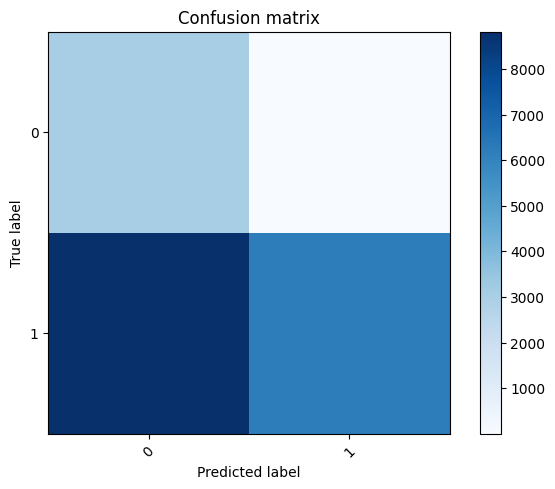

              precision    recall  f1-score   support

           0       0.26      1.00      0.41      3057
           1       1.00      0.41      0.58     14998

    accuracy                           0.51     18055
   macro avg       0.63      0.71      0.50     18055
weighted avg       0.87      0.51      0.55     18055

565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


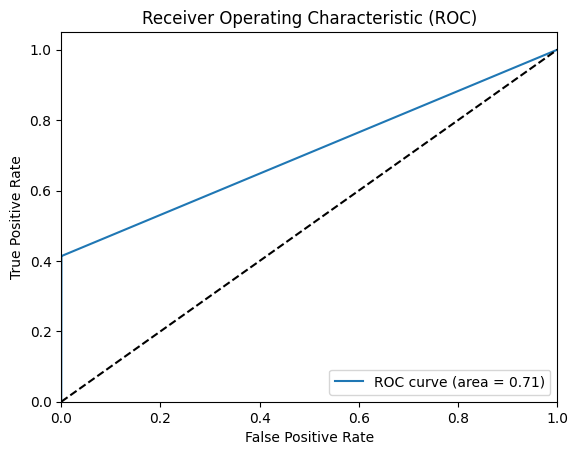

In [271]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
batch_size = 128
#x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
#x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/CNNmodel.keras", verbose=0, save_best_only=True) # save best model
# Reshape x for CNN input
x = x.reshape(x.shape[0], 42, 1)  # Reshape to (num_samples, 42, 1), where 42 is the number of features
x_test = x_test.reshape(x_test.shape[0], 42, 1)
for i in range(2):
    cnn = Sequential()
    # First Conv1D layer
    cnn.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(42, 1), strides=1))  # 42 features, 1 channel
    cnn.add(MaxPooling1D(pool_size=2))

    # Second Conv1D layer
    cnn.add(Conv1D(128, kernel_size=3, activation='relu'))
    cnn.add(MaxPooling1D(pool_size=2))

    cnn.add(Flatten())
    cnn.add(Dense(500, activation="relu"))
    cnn.add(Dropout(0.1))
    cnn.add(Dense(2, activation="softmax"))  # 2 output classes for binary classification

# Compile the CNN model
    cnn.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the CNN model
    cnn.fit(x, y, validation_data=(x_test, y_test),callbacks=[monitor,checkpointer], batch_size=128, epochs=10, verbose=2)
 
model.summary()
from sklearn import metrics

y_true = np.argmax(y_test, axis=1)
pred = cnn.predict(x_test)
pred = np.argmax(pred, axis=1)

accuracy = metrics.accuracy_score(y_true, pred)
f1 = metrics.f1_score(y_true, pred, average='weighted')

print('Accuracy:', accuracy)
print('Averaged F1:', f1)
print(metrics.classification_report(y_true, pred))
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, label)
plt.show()
print(classification_report(y_true, pred))


# Assuming y_test is already one-hot encoded, get the true labels
y_true = np.argmax(y_test, axis=1)
pred = cnn.predict(x_test)
pred = pred[:, 1]
plot_roc(pred, y_true)